In [8]:
import cv2
import os
import random 
import numpy as np

import sys
visualDet3D_path = os.path.dirname(sys.path[0])  #two folders upwards
sys.path.insert(0, visualDet3D_path)

from visualDet3D.networks.lib.pac_module import PerspectiveConv2d
from visualDet3D.utils.util_kitti import kitti_calib_file_parser, init_img_plt_without_bev, load_tf_image

random.seed(2222)
NUM_IMAGE_SHOW = 8

# Image files
IMG_DIR = "../dataset/kitti/training/image_2/"
# Anotations files
ANO_DIR = "../dataset/kitti/training/label_2/"
# Calibration files
CAR_DIR = "../dataset/kitti/training/calib/"

# 
UV_STRIDE = (4, 3) # (u_stride, v_stride)
DIALATION_RATE = (1, 1) # (x ,y)

# 
BEV_SIZE = 400 # pixel
MAX_DIS = 60 # m
AVG_Y3D_CENTER = 0.94677
IMAGE_SHAPE = (288, 1280)
DR = 16 # Downsample ratio



# Visualize PAC with 2d_offset

Update offset cache
Update offset cache
Update offset cache
Update offset cache
Update offset cache
Update offset cache
Update offset cache
Update offset cache


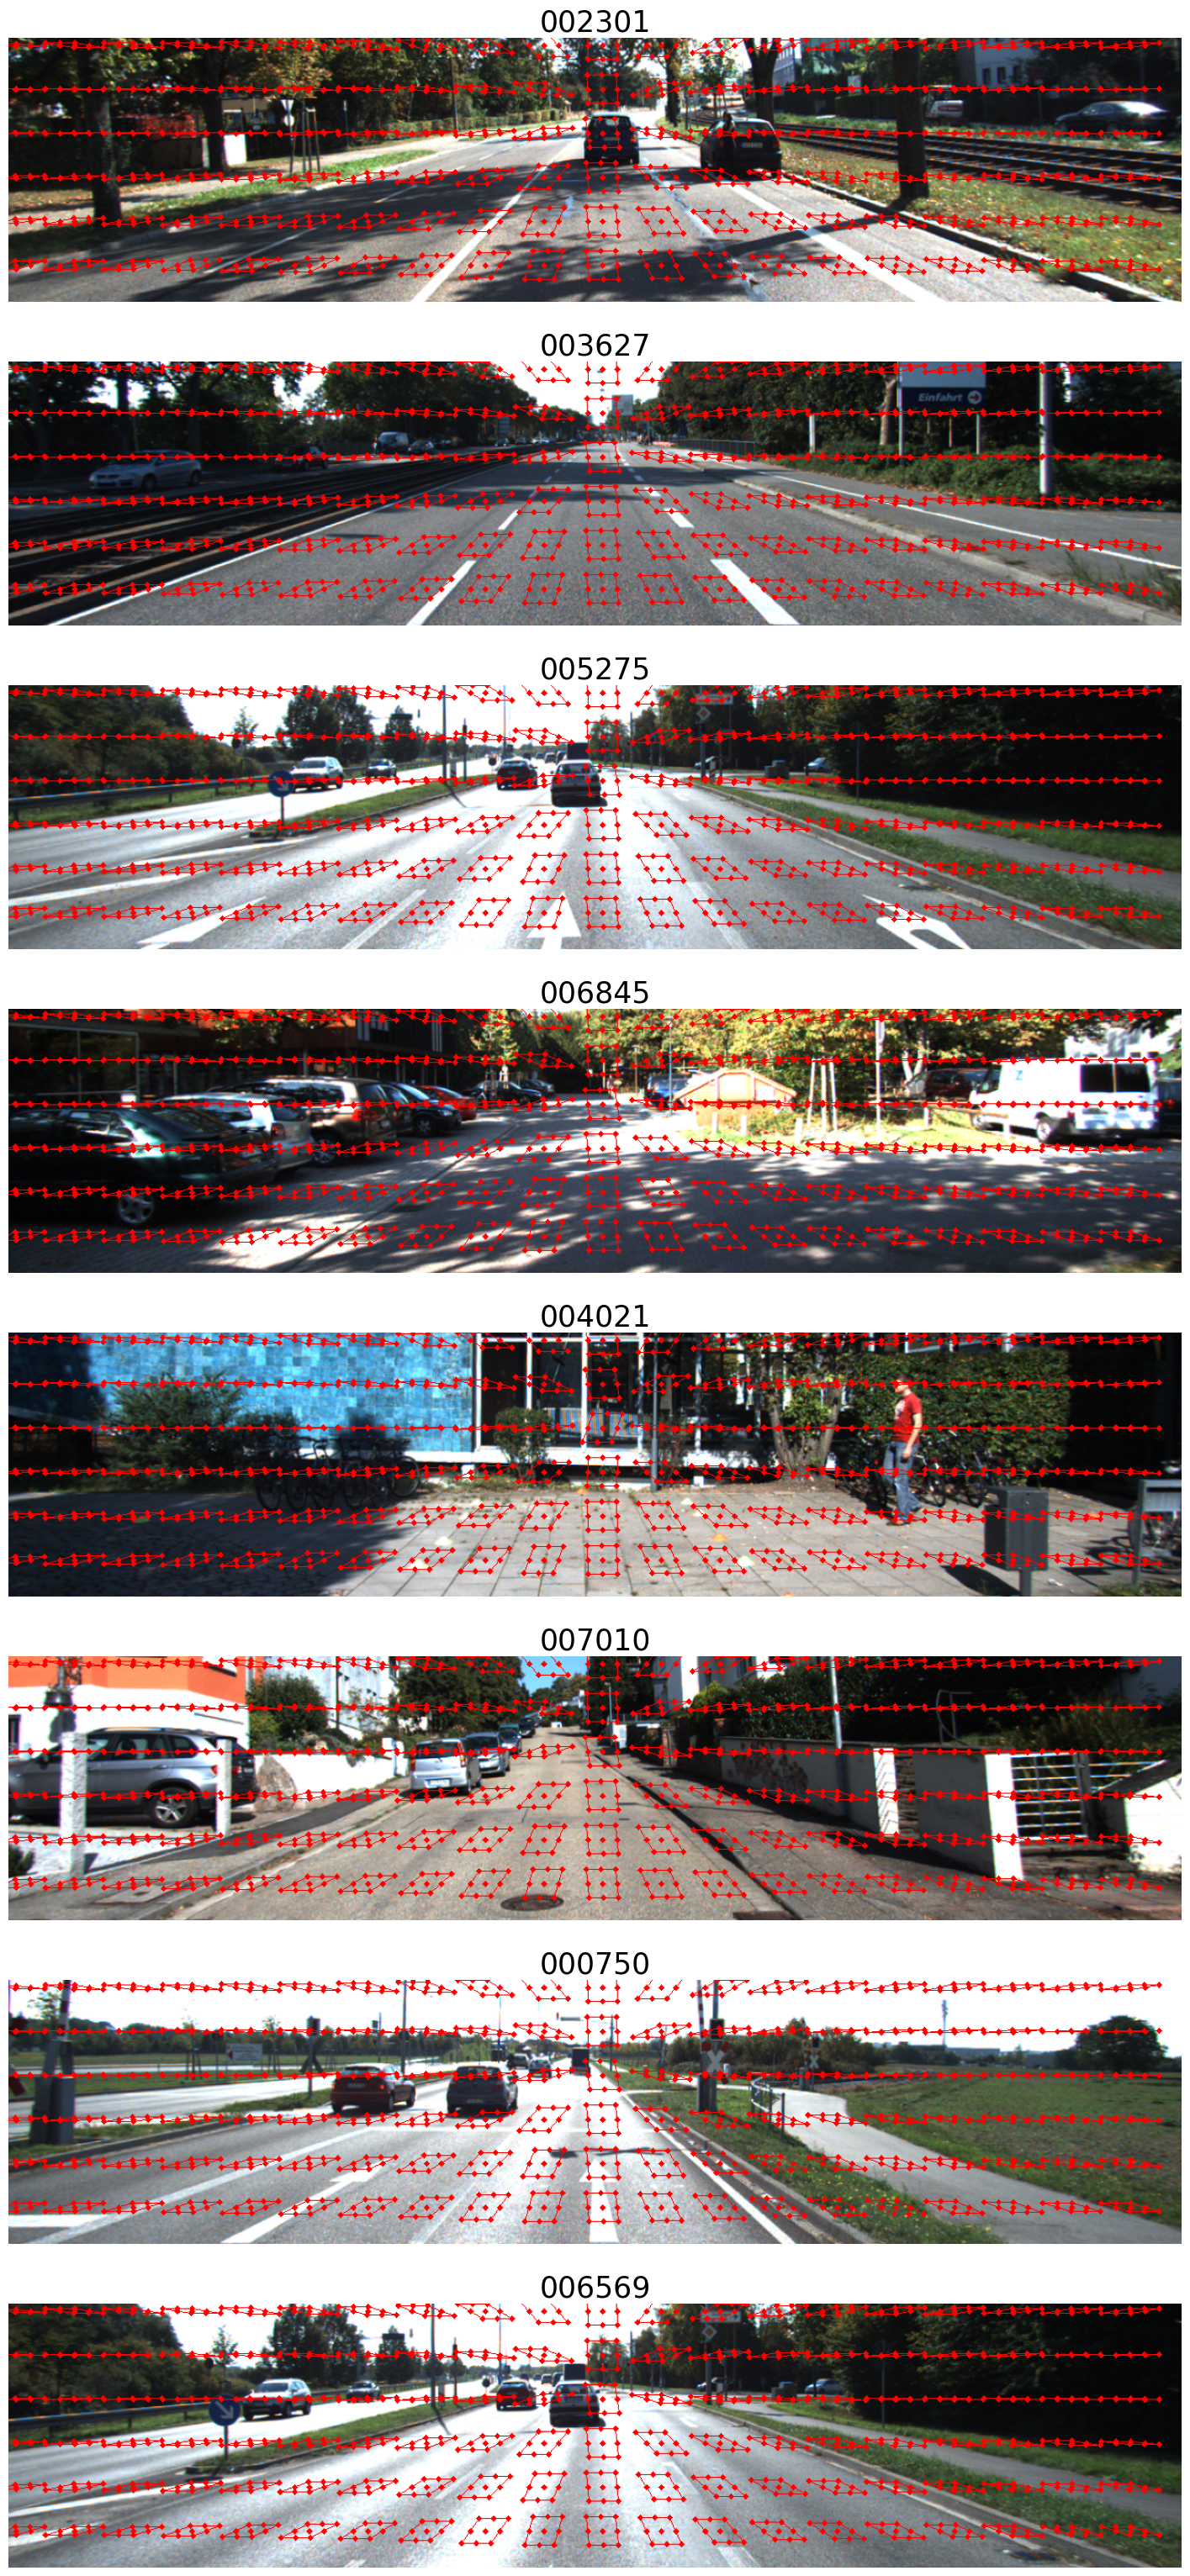

In [9]:
# Get image list
img_names = [i.split('.')[0] for i in os.listdir(IMG_DIR)]
random.shuffle(img_names)
chose_name = img_names[:NUM_IMAGE_SHOW]
chose_name = ['002301', '003627', '005275', '006845', '004021' , '007010', '000750', '006569']

chose_img = []
chose_P2  = []
for i_name, name in enumerate(chose_name):
    
    # Load image
    img = load_tf_image(os.path.join(IMG_DIR, f"{name}.png"))


    # Load calibration matrix
    P2 = kitti_calib_file_parser(os.path.join(CAR_DIR, f"{name}.txt"),
                                 new_shape_tf = IMAGE_SHAPE, 
                                 crop_tf = 100)
    
    pac = PerspectiveConv2d(1, 1, input_shape=[i//16 for i in IMAGE_SHAPE], d_rate_xy = (DIALATION_RATE[0]*DR, DIALATION_RATE[1]*DR), lock_theta_ortho = False)
    
    # Get offset of the kernal location
    offset = pac.get_offset(P2).cpu().numpy() # [1, 18, 18, 80]

    
    for u in range(0, IMAGE_SHAPE[1]//DR, UV_STRIDE[0]):
        for v in range(0, IMAGE_SHAPE[0]//DR, UV_STRIDE[1]):
            
            # Random color
            # color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            color = (0, 0, 255)
            
            # 
            offset_np = offset[0, :, v, u]
            offset_np += np.array([-1,-1,  -1,0,  -1,1,
                                    0,-1,   0,0,   0,1,
                                    1,-1,   1,0,   1,1])
            
            # get all nine pts in the kernal
            pts = []
            for i in range(0, 18, 2):
                pts.append( (int((u + offset_np[i+1] + 0.5)*DR),
                             int((v + offset_np[i  ] + 0.5)*DR)) )

                img = cv2.circle(img, pts[i//2], 1, color, 4)
            
            # draw the kernal polygon on the image
            polygon_pts = np.array([pts[0], pts[2], pts[8], pts[6]], np.int32)
            img = cv2.polylines(img, [polygon_pts.reshape((-1,1,2))], True, color)

    chose_P2.append(P2)
    chose_img.append(img)

axs = init_img_plt_without_bev(chose_img, titles = chose_name)
